<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-предобработка-данных" data-toc-modified-id="Загрузка-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Обработка-дубликатов" data-toc-modified-id="Обработка-дубликатов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обработка дубликатов</a></span></li><li><span><a href="#Обработка-аномалий" data-toc-modified-id="Обработка-аномалий-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обработка аномалий</a></span></li><li><span><a href="#Обработка-пропусков" data-toc-modified-id="Обработка-пропусков-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Обработка пропусков</a></span></li><li><span><a href="#Удаление-признаков" data-toc-modified-id="Удаление-признаков-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Удаление признаков</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект 11. Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Условия задачи**

- Качественно преобработать даные в стобцах и удалить неинформативные признаки.
- Для оценки качества моделей применить метрику *RMSE*.
- Значение метрики *RMSE* должно быть меньше 2500 (евро).
- Обучить и проверить разные модели, одна из которых — **LightGBM**, как минимум одна — не бустинг.
- Модель градиентного бустинга может долго обучаться, поэтому изменять у неё только два-три параметра.

**Ход проекта**

Данные геологоразведки трёх регионов получены из файла `autos.csv`. О качестве данных ничего незивестно.

Решение пройдёт в 5 этапов:

1. Загрузка и предобработка данных.
2. Подготовка данных для машинного обучения.
3. Обучение нескольких моделей.
4. Анализ результатов обучения и выбор наилучшей модели.
5. Общий вывод по итогам работы.

**Описание данных**

Признаки:

- `DateCrawled` — дата скачивания анкеты из базы 
- `VehicleType` — тип автомобильного кузова 
- `RegistrationYear` — год регистрации автомобиля 
- `Gearbox` — тип коробки передач 
- `Power` — мощность (л. с.) 
- `Model` — модель автомобиля 
- `Kilometer`— пробег (км) 
- `RegistrationMonth` — месяц регистрации автомобиля 
- `FuelType` — тип топлива 
- `Brand` — марка автомобиля 
- `Repaired` — была машина в ремонте или нет 
- `DateCreated` — дата создания анкеты 
- `NumberOfPictures` — количество фотографий автомобиля 
- `PostalCode` — почтовый индекс владельца анкеты (пользователя) 
- `LastSeen` — дата последней активности пользователя 

Целевой признак:

- `Price` — цена (евро)

## Загрузка и предобработка данных

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [3]:
RND_STATE = 12345

In [4]:
data = pd.read_csv('autos.csv')

Количество дубликатов: 4


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


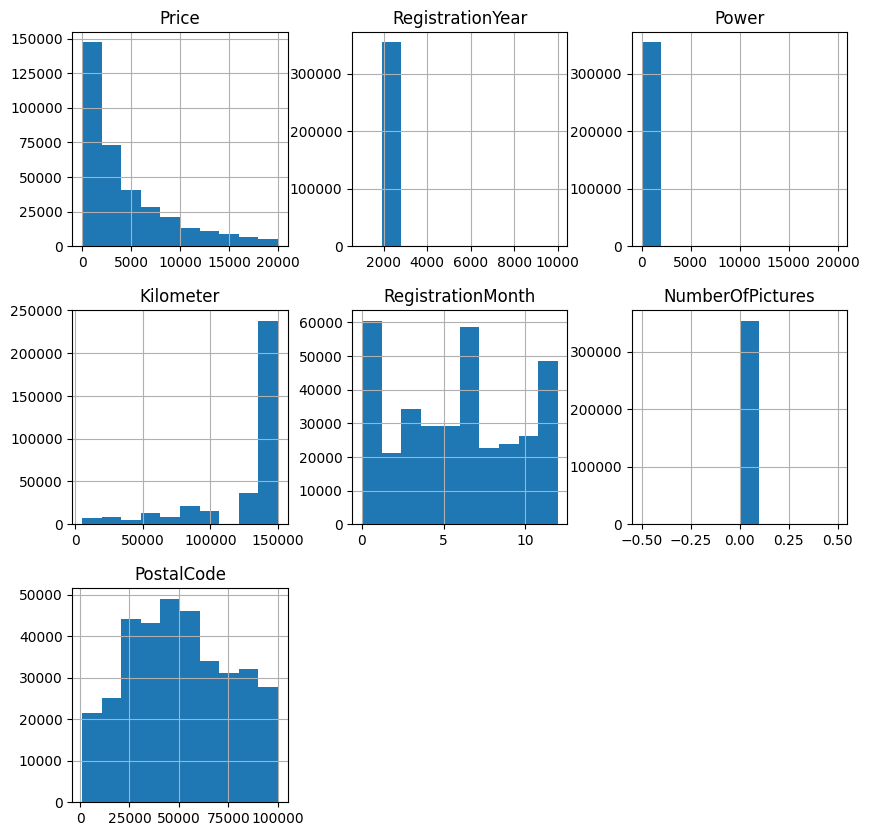

In [5]:
# функция вызывающая все методы для обзора данных
def data_review(data):
    print('Количество дубликатов:', data.duplicated().sum())
    display(data.head(10))
    display(data.info())
    display(data.describe())
    data.hist(figsize=(10, 10));
    
# вызовем функцию, чтобы вывести информацию о датафрейме под номером 0
data_review(data)

Для начала приведем столбцы с датами к правильному типу данных.

In [6]:
date_columns = ['DateCreated', 'DateCrawled', 'LastSeen']

for column in date_columns:
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%d %H:%M:%S')
    print(f'У столбца {column} новый тип данных:', data[column].dtype)

У столбца DateCreated новый тип данных: datetime64[ns]
У столбца DateCrawled новый тип данных: datetime64[ns]
У столбца LastSeen новый тип данных: datetime64[ns]


Выведем описание для столбцов с датами.

In [7]:
data[date_columns].describe()

,DateCreated,DateCrawled,LastSeen
count,354369,354369,354369
unique,109,271174,179150
top,2016-04-03 00:00:00,2016-03-24 14:49:47,2016-04-06 13:45:54
freq,13719,7,17
first,2014-03-10 00:00:00,2016-03-05 14:06:22,2016-03-05 14:15:08
last,2016-04-07 00:00:00,2016-04-07 14:36:58,2016-04-07 14:58:51


Неправильные типы данных в столбцах - это не единственная проблема в данных. Кроме того, в исходном датасете присутствуют пропуски, аномалии и дубликаты. Также присутствуют неинформативные для алгоритмов машинного обучения столбцы. Исправим эти недочеты в данных.

### Обработка дубликатов

Сохраним размер датафрейма до всех предобработок.

In [9]:
df_initial_size = data.shape[0]
df_initial_size

354369

В данных обнаружено 4 дубликата. Посомтрим, что это за строки. Выведем оригиналы строк вместе с повторами.

In [10]:
data[data.duplicated(keep='first')]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


Количество убликатов довольно небольшое, мы можем их спокойно удалить, и это не отразиться на анализе. Исключим дубликаты из выборки.

In [11]:
data = data.drop_duplicates()
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


### Обработка аномалий

Рассмотрим столбец `RegistrationYear`. В нём можно увидеть неправодобнобные значения года регистрации автомобиля.

In [12]:
data[data['RegistrationYear'] == 1000].sample(10, random_state=RND_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
216770,2016-04-02 14:39:35,60,NaN,1000,NaN,0,corsa,5000,0,NaN,opel,NaN,2016-04-02,0,41844,2016-04-02 14:39:35
230741,2016-03-19 12:37:35,0,NaN,1000,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-19,0,36304,2016-03-19 12:37:35
55605,2016-03-10 19:50:17,500,NaN,1000,NaN,0,NaN,5000,0,NaN,citroen,yes,2016-03-10,0,24811,2016-04-06 03:45:53
174893,2016-03-05 19:48:45,0,NaN,1000,NaN,1000,golf,5000,4,petrol,volkswagen,NaN,2016-03-05,0,35716,2016-03-05 22:27:55
71459,2016-03-27 23:46:28,500,NaN,1000,NaN,0,golf,5000,0,NaN,volkswagen,NaN,2016-03-27,0,91628,2016-03-29 13:46:49
119442,2016-03-18 10:37:00,1,NaN,1000,NaN,1000,3er,5000,0,NaN,bmw,NaN,2016-03-18,0,94086,2016-04-05 22:16:13
60017,2016-03-10 12:38:01,80,NaN,1000,NaN,0,NaN,5000,0,NaN,volkswagen,NaN,2016-03-10,0,93107,2016-04-07 04:45:57
16062,2016-03-29 23:42:16,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29,0,47166,2016-04-06 10:44:58
66198,2016-03-08 14:50:20,1300,NaN,1000,auto,0,NaN,5000,6,petrol,sonstige_autos,NaN,2016-03-08,0,13156,2016-03-17 08:17:42
135865,2016-03-07 14:59:17,16500,NaN,1000,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-07,0,23879,2016-03-09 19:15:47


Логически мы понимаем, что машина не может быть зарегестрированна в 1000-ом году. К тому же, судя по данной выборке, строки с некорректной датой регистрации содержат и другие проблемы, такие как пропуски во многих признаках. Это просто по большей части непригодные данные.

Посмотрим на уникальные значения годов, чтобы сформировать характерные для нормы границы.

In [13]:
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

Из описания столбцов с датами мы знаем, что самая поздняя дата скачивания объявления из базы приходится на 2016 год, следовательно в качестве верхней границы мы должны выбрать это значение. В качестве нижней границы 1940 год. Это кажется разумным порогом и сохранит достаточно большую часть выборки.

In [14]:
len(data) - len(data[(data['RegistrationYear'] >= 1940) & (data['RegistrationYear'] <= 2016)])

14752

В результате сокращения исходный датафрейм потеряет около 4-5% данных. Это приемлимые значения, исключим строки с некорректными годами из выборки.

In [15]:
data = data[(data['RegistrationYear'] >= 1940) & (data['RegistrationYear'] <= 2016)]
data.shape[0]

339613

Рассмотрим столбец `Power`.

In [16]:
data['Power'].describe()

count    339613.000000
mean        111.042849
std         186.901753
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Довольно странными выглядят значения 0 и 20000 лошадиных сил. 

In [17]:
data[data['Power'] > 2000].sample(10, random_state=RND_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
197896,2016-03-11 13:58:35,900,wagon,1997,manual,11011,a4,150000,5,gasoline,audi,no,2016-03-11,0,82467,2016-03-19 21:44:26
232025,2016-03-14 11:38:40,0,wagon,1991,auto,9710,e_klasse,150000,1,petrol,mercedes_benz,no,2016-03-14,0,41836,2016-03-14 11:38:40
33952,2016-03-09 11:37:03,3740,small,2006,manual,6920,aygo,90000,10,NaN,toyota,no,2016-03-09,0,94116,2016-03-17 05:16:32
260878,2016-03-20 08:36:59,1500,wagon,2006,manual,10910,NaN,20000,3,petrol,peugeot,yes,2016-03-20,0,56567,2016-03-20 15:42:16
142476,2016-04-01 15:57:34,8600,other,2007,NaN,3500,other,150000,12,NaN,volkswagen,NaN,2016-04-01,0,30855,2016-04-07 13:50:34
309245,2016-04-02 08:55:22,950,small,1998,manual,7511,NaN,150000,3,petrol,volkswagen,no,2016-04-02,0,84339,2016-04-06 07:17:31
87830,2016-03-15 21:55:11,2550,small,2004,auto,6226,fortwo,125000,5,petrol,smart,no,2016-03-15,0,12359,2016-04-07 07:45:21
216993,2016-03-10 08:57:25,11950,convertible,2008,manual,16312,a4,20000,4,petrol,audi,no,2016-03-10,0,51647,2016-03-17 09:16:19
289174,2016-04-03 23:25:35,7799,NaN,2004,auto,2004,NaN,150000,6,petrol,mercedes_benz,yes,2016-04-03,0,55252,2016-04-05 12:10:25
79981,2016-03-27 13:49:10,5500,convertible,2002,manual,2016,3er,150000,2,petrol,bmw,NaN,2016-03-27,0,74538,2016-04-07 09:46:13


In [18]:
len(data[data['Power'] > 2000])

109

В выборке 109 объекто с мощностью более 2000 лошадиных сил. Причем, можно увидеть даже легковые автомобили. Позиции с такой мощностью наверняка аномальны, исключим их из выборки.

In [19]:
data = data[data['Power'] <= 2000]
len(data)

339504

In [20]:
data[data['Power'] == 0].sample(10, random_state=RND_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
79602,2016-03-12 11:00:02,699,NaN,1970,NaN,0,NaN,100000,0,NaN,sonstige_autos,NaN,2016-03-12,0,6369,2016-03-20 09:16:29
264117,2016-03-29 13:56:22,700,sedan,1999,manual,0,other,100000,0,NaN,citroen,no,2016-03-29,0,3053,2016-03-31 06:44:32
16705,2016-03-07 04:40:47,4200,NaN,2016,manual,0,corsa,150000,11,petrol,opel,no,2016-03-06,0,90431,2016-04-07 07:46:50
224051,2016-03-23 18:44:20,400,wagon,1997,manual,0,NaN,150000,11,petrol,mercedes_benz,NaN,2016-03-23,0,18233,2016-03-23 18:44:20
225652,2016-03-14 16:59:03,3100,wagon,2001,manual,0,passat,150000,1,NaN,volkswagen,NaN,2016-03-14,0,44388,2016-03-14 16:59:03
176419,2016-03-12 13:38:38,400,small,1998,NaN,0,corsa,5000,11,petrol,opel,no,2016-03-12,0,31655,2016-03-13 04:46:22
126091,2016-03-28 18:41:14,1350,NaN,2016,NaN,0,golf,150000,5,NaN,volkswagen,NaN,2016-03-28,0,4626,2016-04-01 03:18:21
10165,2016-03-27 13:51:16,4900,sedan,1994,manual,0,c_klasse,90000,7,petrol,mercedes_benz,no,2016-03-27,0,3042,2016-04-07 09:46:15
79568,2016-03-14 17:38:52,1100,NaN,2005,NaN,0,primera,150000,0,NaN,nissan,NaN,2016-03-14,0,12247,2016-03-15 12:17:42
60248,2016-04-02 16:39:00,3000,NaN,2000,NaN,0,a4,150000,0,NaN,audi,NaN,2016-04-02,0,42113,2016-04-06 15:17:52


In [21]:
len(data[data['Power'] == 0])

36335

В датафрейме 36335 значений с нулевым значнием мощности. Просто удалить эти данные мы не можем, поскольку они составляют слишком большую часть выборки. Заменим нули средними значениями, сгруппировав по модели автомобиля.

In [23]:
def fill_zeros(x):
    masked_x = x.mask(x.eq(0))
    filled_x = masked_x.fillna(x.median())
    return filled_x

data['Power'] = data.groupby('Model')['Power'].apply(fill_zeros)
len(data[data['Power'] == 0])

10

Мы сократили значительную часть нулей. Оставшиеся нули заменим на средее по всей выборке.

In [24]:
data.loc[(data['Power'] == 0) | (data['Power'].isna()), 'Power'] = data['Power'].median()
len(data[data['Power'] == 0])

0

Рассмотрим столбец `Price`.

In [25]:
data['Price'].describe()

count    339504.000000
mean       4472.330570
std        4545.822556
min           0.000000
25%        1100.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

В выборке есть объявления с нулевой ценой, но в случае с продажами автомобилей это невозможная ситуация. Посомтрим, что это за строки.

In [26]:
data[data['Price'] == 0].sample(10, random_state=RND_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
183738,2016-04-04 21:44:50,0,wagon,2003,auto,125.0,mondeo,150000,0,gasoline,ford,NaN,2016-04-04,0,39288,2016-04-07 00:16:11
99637,2016-03-13 00:57:32,0,bus,2002,auto,107.0,scenic,150000,1,petrol,renault,NaN,2016-03-13,0,79336,2016-03-20 13:18:33
94975,2016-03-12 21:55:36,0,sedan,1983,manual,150.0,other,90000,1,petrol,opel,no,2016-03-12,0,79427,2016-03-17 02:47:09
54255,2016-03-07 03:53:58,0,small,1995,manual,60.0,polo,150000,0,petrol,volkswagen,yes,2016-03-07,0,28195,2016-04-05 15:16:57
353579,2016-04-02 21:36:16,0,coupe,1999,manual,101.0,a3,150000,1,petrol,audi,no,2016-04-02,0,44652,2016-04-06 22:16:11
13055,2016-03-09 13:57:43,0,small,2000,manual,60.0,polo,150000,0,NaN,volkswagen,NaN,2016-03-09,0,48531,2016-04-06 10:17:18
77579,2016-03-09 13:52:10,0,wagon,2003,auto,150.0,3er,150000,10,gasoline,bmw,yes,2016-03-09,0,22547,2016-03-09 13:52:10
119592,2016-03-26 15:25:25,0,wagon,2002,manual,143.0,3er,125000,8,petrol,bmw,yes,2016-03-26,0,57629,2016-04-06 15:15:28
214792,2016-03-21 06:57:18,0,small,2004,manual,75.0,2_reihe,125000,12,petrol,peugeot,no,2016-03-21,0,66333,2016-03-27 09:55:49
258618,2016-03-06 11:42:14,0,NaN,1995,NaN,150.0,3er,150000,0,NaN,bmw,NaN,2016-03-06,0,57078,2016-03-26 15:45:53


In [27]:
len(data[data['Price'] == 0])

9950

В датафрейме 9950 строк содержат нули признаке цены. К сожалению, заманить эти аномалии на основании данных из таблицы очень тяжело. Не смотря на то, что эти объекты не имеют пропусков в других признаках, нам придется удалить их из выборки. Так мы сократим датафрейм еще на 3% от изначального объема, что находится в пределах допустимого.

In [28]:
data = data[data['Price'] != 0]
len(data)

329554

### Обработка пропусков

In [29]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          19890
RegistrationYear         0
Gearbox              15545
Power                    0
Model                15579
Kilometer                0
RegistrationMonth        0
FuelType             24105
Brand                    0
Repaired             59774
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Рассмотрим пропуски в стобце `VehicleType`.

In [30]:
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [31]:
data['VehicleType'].isna().sum()

19890

Более 19 тыс. пропусков - это слишком большое число, чтобы просто удалить их из датафрейма. Рассмотрим подробнее эти строки.

In [32]:
data[data['VehicleType'].isna()].sample(10, random_state=RND_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
39601,2016-03-06 18:06:34,800,NaN,2016,manual,110.0,NaN,150000,0,NaN,peugeot,NaN,2016-03-06,0,65549,2016-03-13 03:44:19
329256,2016-03-19 13:47:58,500,NaN,2016,manual,64.0,caddy,150000,2,gasoline,volkswagen,yes,2016-03-19,0,19205,2016-03-27 03:15:51
293281,2016-03-28 18:46:20,999,NaN,2016,manual,75.0,golf,150000,1,NaN,volkswagen,NaN,2016-03-28,0,55286,2016-03-30 10:17:18
43041,2016-04-03 12:56:07,790,NaN,2000,NaN,90.0,golf,150000,10,gasoline,volkswagen,NaN,2016-04-03,0,46117,2016-04-05 11:47:09
309724,2016-03-11 14:48:06,550,NaN,1990,NaN,26.0,601,80000,12,NaN,trabant,NaN,2016-03-11,0,37574,2016-03-11 14:48:06
234217,2016-03-16 18:58:59,1300,NaN,1995,NaN,109.0,other,90000,0,NaN,bmw,NaN,2016-03-16,0,32049,2016-03-16 18:58:59
78991,2016-03-07 18:42:29,4300,NaN,2005,manual,110.0,NaN,150000,10,NaN,sonstige_autos,NaN,2016-03-07,0,76532,2016-03-19 16:18:45
209231,2016-03-27 15:51:17,1000,NaN,2000,NaN,110.0,NaN,150000,0,NaN,audi,no,2016-03-27,0,47803,2016-03-30 21:15:27
236541,2016-03-06 22:42:29,1850,NaN,2016,manual,75.0,3_reihe,150000,12,NaN,peugeot,NaN,2016-03-06,0,49084,2016-04-03 01:46:08
113884,2016-03-06 20:48:11,4390,NaN,2005,manual,101.0,golf,150000,12,gasoline,volkswagen,NaN,2016-03-06,0,13627,2016-03-09 15:47:03


Посомтрим, сможем ли мы заполнить пропуски на основе данных о модели машины.

In [33]:
data[(data['Brand'] == 'volkswagen') & (data['Model'] == 'golf')]['VehicleType'].unique()

array([nan, 'small', 'sedan', 'bus', 'other', 'wagon', 'convertible',
       'coupe', 'suv'], dtype=object)

К сожалению, даже кокретная модель машины "volkswagen golf" может продаваться в разных кузовах. Такой способ заполнения пропусков не подойдет. 

На мой взгляд, в данном случае логичным решением будет причислить все пропуски к калссу "other". Посмотрим на соотношение классов в данном столбце.

In [34]:
data['VehicleType'].value_counts()

sedan          89360
small          77973
wagon          63675
bus            28332
convertible    19848
coupe          15624
suv            11786
other           3066
Name: VehicleType, dtype: int64

Классу "other" принадлежит меньше всего объектов, доабвление новых объектов скажется на балансе классов только положительным образом.

In [35]:
data['VehicleType'].fillna('other', inplace=True)
data['VehicleType'].isna().sum()

0

Расссмотрим столбец `Model`.

In [36]:
def show_passes_info(column):
    display(column.unique())
    display(column.value_counts())
    print('Кол-во пропусков:')
    display(column.isna().sum())

In [37]:
show_passes_info(data['Model'])

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'almera', 'megane',
       'lupo', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda',
       'up', 'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira',
       'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1',
       'rio', 'to

golf                  26729
other                 23144
3er                   18667
polo                  12023
corsa                 11586
                      ...  
kalina                    6
rangerover                3
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 250, dtype: int64

Кол-во пропусков:


15579

В данном признаке более 15 тыс. пропусков. Мне не можем их удалить и не можем их заполнить на основании других столбцов. Нам остается только поступить по аналогии с предыдущим столбцом и добавить пропуски в категорию "other". На балансе классов это действие не отразится.

In [38]:
data['Model'].fillna('other', inplace=True)
data['Model'].isna().sum()

0

Рассмотрим столбец `FuelType`.

In [39]:
show_passes_info(data['FuelType'])

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

petrol      204604
gasoline     94822
lpg           5022
cng            532
hybrid         220
other          162
electric        87
Name: FuelType, dtype: int64

Кол-во пропусков:


24105

В столбце с типом топлива более 24 тыс. пропусков. На мой взгляд, здесь тоже стоит заполнить пропуски значением "other".

In [40]:
data['FuelType'].fillna('other', inplace=True)
data['FuelType'].isna().sum()

0

Рассотрим столбец `Gearbox`.

In [41]:
show_passes_info(data['Gearbox'])

array(['manual', 'auto', nan], dtype=object)

manual    251037
auto       62972
Name: Gearbox, dtype: int64

Кол-во пропусков:


15545

В данном столбце более 15 тыс. пропусков и всего две возможные категории. Поскольку очень сложно заполнить данные пропуски с помощью других столбцов, мы можем добавить еще одну категорию ("unknown") в данный столбец.

In [42]:
data['Gearbox'].fillna('unknown', inplace=True)
data['Gearbox'].isna().sum()

0

Рассмотрим признак `Repaired`.

In [43]:
show_passes_info(data['Repaired'])

array([nan, 'yes', 'no'], dtype=object)

no     236846
yes     32934
Name: Repaired, dtype: int64

Кол-во пропусков:


59774

Это тоже бинарный признак и он содержит боле 59 тыс. пропусков. Заполним пропуски в данном признаке так же, как и в предыдущем, добавим категорию "unknown".

In [44]:
data['Repaired'].fillna('unknown', inplace=True)
data['Repaired'].isna().sum()

0

Убедимся, что все пропуски обработанны.

In [45]:
lost_data = (df_initial_size - data.shape[0]) / df_initial_size * 100
print(f'Процент потерянных данных: {np.round(lost_data)}%')

Процент потерянных данных: 7.0%


In [46]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

### Удаление признаков

В нашем датафрейме присутсвуют признаки, которые не несут никакой ценной информации для агоритмов обучения. Для лучшего обучения их следует удалить из выборки. К таким признакам относятся следующие столбцы: `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`.

In [47]:
to_drop = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

data = data.drop(to_drop, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329554 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             329554 non-null  int64  
 1   VehicleType       329554 non-null  object 
 2   RegistrationYear  329554 non-null  int64  
 3   Gearbox           329554 non-null  object 
 4   Power             329554 non-null  float64
 5   Model             329554 non-null  object 
 6   Kilometer         329554 non-null  int64  
 7   FuelType          329554 non-null  object 
 8   Brand             329554 non-null  object 
 9   Repaired          329554 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 27.7+ MB


**Вывод**

Предобработка обнаружила три проблемы в данных:
- пропущенные значения,
- явные дубликаты,
- аномальные значения,
- лишние признаки.

Мы заполнили пропуски там, где это возможно. Избавились от дубликатов и выбивающихся неправдобоных значений, что сделает обучение моделей более качествнным. Количество удаленных строк не превышает 10% от изначального объема датафрейма. Лишние признаки были убраны из датафрейма.

Теперь можно переходить к разбиению данных на выборки и подготовке к машинному обучению.

## Подготовка данных

Разделим данные на тренировочную и тестовую выборки.

In [48]:
features = data.drop('Price', axis=1)
target = data['Price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=RND_STATE)

print('Тренировочная выборка: ', features_train.shape)
print('Тестовая: ', features_test.shape)

Тренировочная выборка:  (247165, 9)
Тестовая:  (82389, 9)


В данном проекте я планирую обучить три модели: **CatBoost**, **LightGBM** и **RandomForest**. Для обучения CatBoost больше не нужно никаких подготовительных операция над данными, но для обучения LightGBM и RandomForest требуется некоторая проработка категориальных признаков.

Приведем категориальные столбцы в необходимый для LightGBM тип данных.

In [49]:
categorial = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numerical = ['RegistrationYear', 'Power', 'Kilometer']

In [50]:
features_train_lgbm = features_train.copy()
features_test_lgbm = features_test.copy()

features_train_lgbm[categorial] = features_train_lgbm[categorial].astype('category')
features_test_lgbm[categorial] = features_test_lgbm[categorial].astype('category')

features_train_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247165 entries, 76102 to 234017
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       247165 non-null  category
 1   RegistrationYear  247165 non-null  int64   
 2   Gearbox           247165 non-null  category
 3   Power             247165 non-null  float64 
 4   Model             247165 non-null  category
 5   Kilometer         247165 non-null  int64   
 6   FuelType          247165 non-null  category
 7   Brand             247165 non-null  category
 8   Repaired          247165 non-null  category
dtypes: category(6), float64(1), int64(2)
memory usage: 9.2 MB


Закодируем категориальные признаки для RandomForest с помощью OrdinalEncoder.

In [51]:
encoder = OrdinalEncoder()
encoder.fit(features_train[categorial]) 

def features_encoding(x, encoder):
    encoded_features = encoder.transform(x[categorial]) 
    features_categorial = pd.DataFrame(encoded_features, columns=categorial, index=x.index)
    features_df = pd.concat([features_categorial, x[numerical]], axis=1)
    return features_df

features_train_rf = features_encoding(features_train, encoder)
features_test_rf = features_encoding(features_test, encoder)
features_train_rf.head()

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,RegistrationYear,Power,Kilometer
76102,7.0,1.0,139.0,6.0,34.0,2.0,1992,200.0,150000
248052,5.0,1.0,102.0,6.0,10.0,0.0,2005,150.0,100000
139044,2.0,1.0,28.0,6.0,1.0,1.0,1999,150.0,150000
1694,3.0,2.0,232.0,2.0,39.0,1.0,2000,163.0,5000
186068,1.0,1.0,42.0,6.0,24.0,0.0,2005,147.0,50000


**Вывод**

В данном разделе мы:
- разделили данные на выбрки,
- преобразовали типы данных для **LightGBM**,
- преобразовали категориальные признаки для **RandomForest**.

Данные подготовлены и теперь мы можем переходить к обучению моделей.

## Обучение моделей

### RandomForest

Обучим модель RandomForest.

In [53]:
%%time


model_rf = RandomForestRegressor(random_state=RND_STATE)
parameters = {'n_estimators': range (50, 201, 50),
              'max_depth': range (4, 10, 2)}
scores_rf = GridSearchCV(model_rf, 
                         parameters, 
                         scoring='neg_root_mean_squared_error', 
                         cv=3, 
                         n_jobs=-1)
scores_rf.fit(features_train_rf, target_train)
rmse_rf = np.round(np.abs(scores_rf.best_score_))

print('Значения гиперпараметров лучшей модели:', scores_rf.best_params_)
print('Лучшая оценка качества модели:', rmse_rf)

Значения гиперпараметров лучшей модели: {'max_depth': 8, 'n_estimators': 200}
Лучшая оценка качества модели: 2086.0
CPU times: total: 53.6 s
Wall time: 4min 12s


In [54]:
rf_learning_results = pd.DataFrame(scores_rf.cv_results_).sort_values(by='rank_test_score')
rf_learning_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
11,54.927925,0.903071,1.071783,0.049985,8,200,"{'max_depth': 8, 'n_estimators': 200}",-2100.906142,-2081.268334,-2076.030519,-2086.068332,10.707603,1
9,41.797241,0.304876,0.864641,0.014731,8,100,"{'max_depth': 8, 'n_estimators': 100}",-2101.513529,-2081.069349,-2075.697073,-2086.093317,11.122126,2
10,52.464025,3.680970,1.062578,0.101263,8,150,"{'max_depth': 8, 'n_estimators': 150}",-2101.309792,-2081.725004,-2075.754190,-2086.262996,10.915348,3
8,21.198505,0.260125,0.437529,0.000001,8,50,"{'max_depth': 8, 'n_estimators': 50}",-2102.094782,-2083.229597,-2079.565763,-2088.296714,9.870695,4
6,49.957937,0.447693,0.906313,0.012757,6,150,"{'max_depth': 6, 'n_estimators': 150}",-2300.637289,-2278.608113,-2272.611942,-2283.952448,12.049245,5
5,33.778414,0.149558,0.609418,0.012759,6,100,"{'max_depth': 6, 'n_estimators': 100}",-2300.487285,-2278.355367,-2274.138265,-2284.326972,11.556031,6
7,67.103521,0.890213,1.276058,0.115830,6,200,"{'max_depth': 6, 'n_estimators': 200}",-2300.211266,-2279.269211,-2274.770457,-2284.750311,11.085742,7
4,17.064178,0.298738,0.337947,0.047507,6,50,"{'max_depth': 6, 'n_estimators': 50}",-2299.769982,-2280.277576,-2276.126048,-2285.391202,10.307627,8
2,37.140083,0.259544,0.676747,0.014596,4,150,"{'max_depth': 4, 'n_estimators': 150}",-2589.102431,-2552.975865,-2559.918255,-2567.332183,15.652624,9
3,48.126326,0.377363,0.802140,0.029466,4,200,"{'max_depth': 4, 'n_estimators': 200}",-2588.025754,-2554.568509,-2563.570326,-2568.721530,14.136194,10


С помощью GridSearchCV мы выполнили кросс-валидацию и перебрали несколько значений гиперпараметров для RandomForest. Инструмент считает, что лучшей оказалось модель с глубиной дерева 8 и количеством деревьев 200. Однако, оценивая таблицу результатов, мы можем увидеть, что, начиная с эксперимента с индексом 8, целевая метрика *RMSE* практически не менялась, но времени на обучение в данном эксперименте ушло гораздо меньше.

In [55]:
other_experiment_score = scores_rf.cv_results_['mean_test_score'][8]
other_experiment_params = scores_rf.cv_results_['params'][8]
other_experiment_time = scores_rf.cv_results_['mean_fit_time'][8]
print('RMSE модели с индексом 8:', np.round(np.abs(other_experiment_score)))
print('Параметры модели с индексом 8:', other_experiment_params)
print(f'Среднее время обечения модели с инексом 8: {np.round(other_experiment_time, 2)} сек')

RMSE модели с индексом 8: 2088.0
Параметры модели с индексом 8: {'max_depth': 8, 'n_estimators': 50}
Среднее время обечения модели с инексом 8: 21.2 сек


На мой взгляд, разница в *RMSE* небольшая, а времени на обучение 200 деревьев уходит в разы больше, чем на обучение 50 деревьев.

Таким образом, в качестве лучшей модели случайного леса выберем модель со следующими гиперпараметрами: max_depth=8, n_estimators=50. Данная модель выдаёт следующие результаты: *RMSE* — 2088, среднее время на обучение — 21.2 секунд, среднее время на предсказание — 0.37 секунд. В целом, на обучение моделей случайного леса и подбор гиперпараметров ушло 4 минуты 12 секунд.

### LightGBM

Обучим модель LightGBM.

In [52]:
%%time


model_lgbm = LGBMRegressor(learning_rate=0.2, random_state=RND_STATE)
parameters = {'max_depth': [4, 8],
              'n_estimators': [100, 200]}
scores_lgbm = GridSearchCV(model_lgbm, 
                           parameters, 
                           scoring='neg_root_mean_squared_error',
                           cv=3,
                           n_jobs=-1)
scores_lgbm.fit(features_train_lgbm, target_train)
rmse_lgbm = np.round(np.abs(scores_lgbm.best_score_))

print('Значения гиперпараметров лучшей модели:', scores_lgbm.best_params_)
print('Лучшая оценка качества модели:', rmse_lgbm)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 247165, number of used features: 9
[LightGBM] [Info] Start training from score 4615.202310
Значения гиперпараметров лучшей модели: {'max_depth': 8, 'n_estimators': 200}
Лучшая оценка качества модели: 1634.0
CPU times: total: 5.47 s
Wall time: 20.7 s


In [56]:
lgbm_learning_results = pd.DataFrame(scores_lgbm.cv_results_).sort_values(by='rank_test_score')
lgbm_learning_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,2.829774,0.218416,0.399533,0.084162,8,200,"{'max_depth': 8, 'n_estimators': 200}",-1638.510777,-1632.415593,-1632.529370,-1634.485247,2.846859,1
2,3.708418,1.004371,0.257820,0.100107,8,100,"{'max_depth': 8, 'n_estimators': 100}",-1668.372905,-1654.073953,-1654.399073,-1658.948644,6.665281,2
1,3.936877,0.519311,0.623528,0.091433,4,200,"{'max_depth': 4, 'n_estimators': 200}",-1694.537036,-1683.759029,-1672.152023,-1683.482696,9.140732,3
0,2.421605,0.067428,0.463343,0.007319,4,100,"{'max_depth': 4, 'n_estimators': 100}",-1736.883038,-1722.072516,-1705.996356,-1721.650637,12.612963,4


По таблице видно, что с ростом количества дерьевьев и максимальной глубины качество модели возрастает. К сожалению, модели с большими значениями гиперпараметров и обучаться будут гораздо дольше. По этой причине в качестве лучшей выбрем ту модель, которая дала лучший показатель метрики *RMSE* на устаовленном диапозоне гиперпараметров.

Таким образом, лучшая **LightGBM** модель обучалась со следующими значениями гиперпараметров: max_depth=8, n_estimators=200. Данная модель выдаёт следующие результаты: *RMSE* — 1634, среднее время на обучение — 2.83 секунд, среднее время на предсказание — 0.39 секунд. В целом, на обучение моделей случайного леса и подбор гиперпараметров ушло 20 секунд.

### CatBoost

Обучим модель CatBoost.

In [57]:
%%time


model_cbr = CatBoostRegressor(learning_rate=0.2, random_seed=RND_STATE, cat_features=categorial)
parameters  = {'depth': [4, 8],
               'iterations': [100, 200], 
               'verbose': [0]}
scores_cbr = GridSearchCV(model_cbr, 
                          parameters, 
                          scoring='neg_root_mean_squared_error', 
                          cv=3, 
                          n_jobs=-1)
scores_cbr.fit(features_train, target_train)
rmse_cbr = np.round(np.abs(scores_cbr.best_score_))

print('Значения гиперпараметров лучшей модели:', scores_cbr.best_params_)
print('Лучшая оценка качества модели:', rmse_cbr)

C:\Users\Admin\MyPrograms\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [           nan            nan -1721.49920275 -1668.26369803]
  warnings.warn(


Значения гиперпараметров лучшей модели: {'depth': 8, 'iterations': 200, 'verbose': 0}
Лучшая оценка качества модели: 1668.0
CPU times: total: 3min 40s
Wall time: 2min 16s


In [58]:
cbr_learning_results = pd.DataFrame(scores_cbr.cv_results_).sort_values(by='rank_test_score')
cbr_learning_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_verbose,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,84.848380,8.212377,0.276397,0.073084,8,200,0,"{'depth': 8, 'iterations': 200, 'verbose': 0}",-1672.587475,-1668.082209,-1664.121410,-1668.263698,3.458638,1
2,33.183784,0.224586,0.507489,0.070436,8,100,0,"{'depth': 8, 'iterations': 100, 'verbose': 0}",-1731.491035,-1716.804950,-1716.201623,-1721.499203,7.069585,2
0,7.878734,10.052571,0.155628,0.220091,4,100,0,"{'depth': 4, 'iterations': 100, 'verbose': 0}",-1861.225896,NaN,NaN,NaN,NaN,3
1,35.356838,25.119461,0.182733,0.129501,4,200,0,"{'depth': 4, 'iterations': 200, 'verbose': 0}",NaN,-1764.662065,-1769.352389,NaN,NaN,4


По аналогии с LightGBM, мы можем видеть, что наилучший результат в обучении CatBoost даёт модель с наибольшими значениями гиперпараметров из заданного диапозона. 

Таким образом, лучшая **CatBoost** модель имеет следующие значения гиперпараметров:: max_depth=8, iterations=200. Данная модель выдаёт следующие результаты: *RMSE* — 1668, среднее время на обучение — 84.84 секунд, среднее время на предсказание — 0.27 секунд. В целом, на обучение моделей случайного леса и подбор гиперпараметров ушло 2 минут 16 секунд.

**Вывод**

В данном разделе мы провели обучение с кросс-валидацией и подбор гиперпараметров для трех моделей: **RandomForest**, **LightGBM**, **CatBoost**. Наилушими показателями по скорости обучения и метрике *RMSE* обладает модель **LightGBM**, чуть хуже себя показала **CatBoost**, и самый неудачный результат показала модель **RandomForest**. 

Проверим данные модели на тестовой выборке, проведем анализ и определим окончательного лидера.

## Анализ моделей

Протестируем RandomForest.

In [59]:
predictions_rf = scores_rf.best_estimator_.predict(features_test_rf)
rmse_rf_result = mean_squared_error(target_test, predictions_rf, squared=False) 
print('RMSE модели RandomForest:', np.round(np.abs(rmse_rf_result)))

RMSE модели RandomForest: 2087.0


Протестируем LightGBM.

In [60]:
predictions_lgbm = scores_lgbm.best_estimator_.predict(features_test_lgbm)
rmse_lgbm_result = mean_squared_error(target_test, predictions_lgbm, squared=False) 
print('RMSE модели RandomForest:', np.round(np.abs(rmse_lgbm_result)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE модели RandomForest: 1612.0


Протестируем CatBoost.

In [61]:
predictions_cbr = scores_cbr.best_estimator_.predict(features_test)
rmse_cbr_result = mean_squared_error(target_test, predictions_cbr, squared=False) 
print('RMSE модели RandomForest:', np.round(np.abs(rmse_cbr_result)))

RMSE модели RandomForest: 1641.0


Составим таблицу результатов.

In [64]:
result_table = pd.DataFrame([
    ['RndomForest', 
     np.round(np.abs(scores_rf.cv_results_['mean_test_score'][8])), 
     np.round(np.abs(rmse_rf_result)), 
     scores_rf.cv_results_['mean_fit_time'][8], 
     scores_rf.cv_results_['mean_score_time'][8]],
    ['LightGBM', 
     rmse_lgbm, 
     np.round(np.abs(rmse_lgbm_result)), 
     scores_lgbm.cv_results_['mean_fit_time'][3], 
     scores_lgbm.cv_results_['mean_score_time'][3]],
    ['CatBoost',
     rmse_cbr,
     np.round(np.abs(rmse_cbr_result)), 
     scores_cbr.cv_results_['mean_fit_time'][3], 
     scores_cbr.cv_results_['mean_score_time'][3]]
],
    columns = ['model',
           'RMSE на валидации', 
           'RMSE на тесте',
           'Время на обучение (сек),',
           'Время на предсказание (сек)'])

result_table

,model,RMSE на валидации,RMSE на тесте,"Время на обучение (сек),",Время на предсказание (сек)
0,RndomForest,2088.0,2087.0,21.198505,0.437529
1,LightGBM,1634.0,1612.0,2.829774,0.399533
2,CatBoost,1668.0,1641.0,84.848380,0.276397


**Вывод**

Мы провели тестирование отобранных на предыдущем этапе моделей. Лучшей практически по всем показателям оказалась модель **LightGBM**. Значения метрик лучшей модели: *RMSE* на кросс-валидации — 1634, *RMSE* на тестовой выборке — 1612, время на обучение модели — 2.83 секунд, время на предсказание — 0.39 секунд. Значения гиперпараметров лучшей модели:   max_depth=8, n_estimators=200. 

## Общий вывод

В ходе исследования мы провели работу для прогнозирования рыночной стоимости автомобиля.


Исследуя данные, мы:
1. Загрузили и изучили данные.
2. Выполнили предобработку данных. Избавились от дубликатов, обработали аномалии и пропуски.
3. Проанализировали признаки, исключили неифнормативные признаки.
4. Подготовили данные к машинному обучению.
5. Выполнили обучение с кросс-валидацией и подбором гиперпараметров для трех моделей: **RandomForest**, **LightGBM**, **CatBoost**.
6. Отобрали с помощью GridSearchCV модели и оптимальными гиперпараметрами и протестировали их.
7. Проанализировали результаты. Лучшей практически по всем показателям оказалась модель **LightGBM**.  Значения метрик лучшей модели: *RMSE* на кросс-валидации — 1634, *RMSE* на тестовой выборке — 1612, время на обучение модели — 2.83 секунд, время на предсказание — 0.39 секунд. Значения гиперпараметров лучшей модели:   max_depth=8, n_estimators=200.  Именно эту модель я рекомендую для использования, основываясь на требованиях заказчика.